# song id, 제목, 가수, 가사 크롤링

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import concurrent.futures

# 멜론 TOP 100 차트 페이지 URL
url = 'https://www.melon.com/chart/index.htm'

# 웹 페이지 요청
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)

# BeautifulSoup 객체 생성
soup = BeautifulSoup(response.text, 'html.parser')

# 곡 ID, 제목, 아티스트 추출
song_ids = []
song_titles = []
song_artists = []

for song_tag in soup.find_all('tr', class_='lst50') + soup.find_all('tr', class_='lst100'):
    song_id = song_tag.get('data-song-no')
    if song_id:
        title_tag = song_tag.find('div', class_='rank01').find('a')
        artist_tag = song_tag.find('div', class_='rank02').find('a')
        song_ids.append(song_id)
        song_titles.append(title_tag.text)
        song_artists.append(artist_tag.text)

# 곡 가사 추출 함수
def get_lyrics(song_id):
    song_url = f'https://www.melon.com/song/detail.htm?songId={song_id}'
    song_response = requests.get(song_url, headers=headers)
    song_soup = BeautifulSoup(song_response.text, 'html.parser')
    lyrics_tag = song_soup.find('div', class_='lyric')
    if lyrics_tag:
        return lyrics_tag.text.strip()
    else:
        return ""

# 병렬 처리로 가사 추출
def fetch_lyrics(song_id):
    return song_id, get_lyrics(song_id)

# 병렬처리를 위해 ThreadPoolExecutor 사용
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(fetch_lyrics, song_ids))

# 결과 처리
lyrics_dict = dict(results)
lyrics_list = [lyrics_dict[song_id] for song_id in song_ids]

# 데이터프레임 생성
data = {'Song ID': song_ids, 'Title': song_titles, 'Artist': song_artists, 'Lyrics': lyrics_list}
df = pd.DataFrame(data)

# CSV 파일로 저장
df.to_csv('melon_top_100_with_lyrics.csv', index=False, encoding='utf-8-sig')

print("CSV 파일이 저장되었습니다.")


CSV 파일이 저장되었습니다.


# 워드 클라우드로 나타내기 

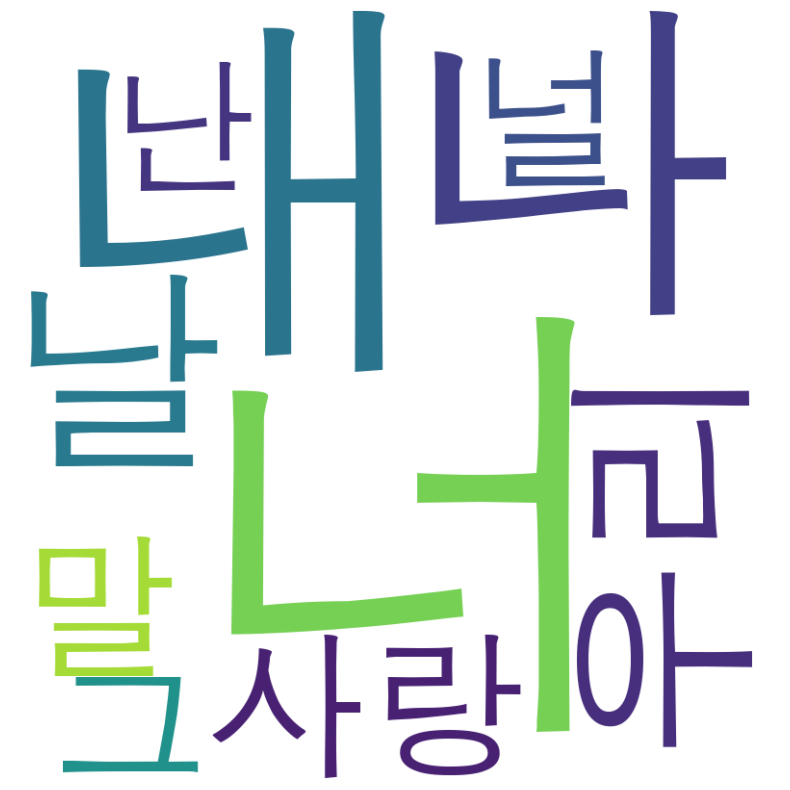

In [3]:
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 데이터 로드
df = pd.read_csv('melon_top_100_with_lyrics.csv')

# 가사 데이터를 하나의 텍스트로 결합
lyrics_text = " ".join(df['Lyrics'].dropna().tolist())

# 한글 형태소 분석기 Okt 사용
okt = Okt()
nouns = okt.nouns(lyrics_text)  # 명사만 추출

# 명사 빈도수 카운트
count = Counter(nouns)

# 많이 사용된 단어 추출 (상위 10개)
most_common_nouns = dict(count.most_common(10))

# 워드클라우드 생성
wordcloud = WordCloud(font_path='/Library/Fonts/AppleGothic.ttf', width=800, height=800, background_color='white').generate_from_frequencies(most_common_nouns)

# 워드클라우드 시각화
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


불용어 추가 버전(미완성)

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

# 멜론 TOP 100 차트 페이지 URL
url = 'https://www.melon.com/chart/index.htm'

# 웹 페이지 요청
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)

# BeautifulSoup 객체 생성
soup = BeautifulSoup(response.text, 'html.parser')

# 곡 ID, 제목, 아티스트 추출
song_ids = []
song_titles = []
song_artists = []

for song_tag in soup.find_all('tr', class_='lst50') + soup.find_all('tr', class_='lst100'):
    song_id = song_tag.get('data-song-no')
    if song_id:
        title_tag = song_tag.find('div', class_='rank01').find('a')
        artist_tag = song_tag.find('div', class_='rank02').find('a')
        song_ids.append(song_id)
        song_titles.append(title_tag.text)
        song_artists.append(artist_tag.text)

# 곡 가사 추출 함수
def get_lyrics(song_id):
    song_url = f'https://www.melon.com/song/detail.htm?songId={song_id}'
    song_response = requests.get(song_url, headers=headers)
    song_soup = BeautifulSoup(song_response.text, 'html.parser')
    lyrics_tag = song_soup.find('div', class_='lyric')
    if lyrics_tag:
        return lyrics_tag.text.strip()
    else:
        return ""

# 불용어 읽기
with open('stopwords.txt', 'r', encoding='utf-8') as file:
    stopwords = set(file.read().split())

# 불용어 제거 함수
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

# 병렬 처리로 가사 추출 및 저장
lyrics_list = []
with ThreadPoolExecutor(max_workers=10) as executor:
    future_to_song_id = {executor.submit(get_lyrics, song_id): song_id for song_id in song_ids}
    for future in as_completed(future_to_song_id):
        song_id = future_to_song_id[future]
        try:
            lyrics = future.result()
            cleaned_lyrics = remove_stopwords(lyrics)
            lyrics_list.append(cleaned_lyrics)
        except Exception as e:
            print(f'Error fetching lyrics for song ID {song_id}: {e}')
            lyrics_list.append("")

# 데이터프레임 생성
data = {'Song ID': song_ids, 'Title': song_titles, 'Artist': song_artists, 'Lyrics': lyrics_list}
df = pd.DataFrame(data)

# CSV 파일로 저장
df.to_csv('melon_top_100_with_lyrics(Ver.1).csv', index=False, encoding='utf-8-sig')

print("CSV 파일이 저장되었습니다.")


CSV 파일이 저장되었습니다.
